In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pic
from sklearn.model_selection import train_test_split

from utils import *
from templates import *

In [2]:
def compute_mean_ranks(per_trace: np.ndarray, key: np.ndarray, bins=10, repeat=500):
    mean_ranks = np.zeros((per_trace.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * per_trace.shape[0] // bins

        rank = np.zeros(per_trace.shape[1], dtype=int)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
            rank += guessing_entropy(np.sum(per_trace[subset], axis=0), key)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks

def compute_mean_ranks_keyround(per_trace_keyround: np.ndarray, keyrounds: np.ndarray, bins=10, repeat=100):
    mean_ranks = np.zeros((per_trace_keyround.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * per_trace_keyround.shape[0] // bins

        rank = np.zeros(per_trace_keyround.shape[1], dtype=np.float64)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace_keyround.shape[0], size=n_traces, replace=False)
            rank += np.mean(guessing_entropy(per_trace_keyround[subset], keyrounds[subset]), axis=0)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks

In [3]:
# 400'000 traces
with open("../labels_pics/seeds_traces_key_labels_400000.pic", "rb") as r:
    seeds_total, traces_total, key, round_perms_labels, copy_perms_labels, masks_labels, rws_perms_labels, rws_masks_labels = pic.load(r)

In [7]:
# 750'000 traces
with open("../labels_pics/seeds_key_labels_739094.pic", "rb") as r:
    seeds_total, key, rws_perms_labels, round_perms_labels, copy_perms_labels, rws_masks_labels, round_masks_labels = pic.load(r)

In [12]:
# 1'000'000 traces
with open("../labels_pics/seeds_key_labels_1000000.pic", "rb") as r:
    seeds_total, key, rws_perms_labels, round_perms_labels, copy_perms_labels, rws_masks_labels, round_masks_labels = pic.load(r)

## 295'000 - 100'000, round 0, masks together

In [4]:
TEST_SIZE = 100_000

In [6]:
with open("y_extraction/y_extraction_epoch_35.pic", "rb") as r:
    y_predicted = pic.load(r)

In [ ]:
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
round_masks_probas = np.stack(y_predicted[2:], axis=1)[:, np.newaxis, ...]

per_trace = classifications_per_trace("preds_per_trace/per_trace_300000_round_0.pic", seeds_extraction, round_perm_probas, copy_perm_probas, round_masks_probas, parallel=False)
recovered_key = reconstruct_key(per_trace)

In [13]:
np.count_nonzero(recovered_key == key) / 512

0.16015625

## 295'000 - 100'000, round 0

In [4]:
TEST_SIZE = 100_000

In [5]:
with open("y_extraction/y_extraction_300000_ind_masks.pic", "rb") as r:
    y_predicted = pic.load(r)

In [6]:
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
round_masks_probas = np.stack([np.stack(y_predicted[i:i+2], axis=1) for i in range(2, len(y_predicted), 2)], axis=1)[:, np.newaxis, ...]

per_trace = classifications_per_trace("preds_per_trace/per_trace_300000_ind_masks.pic", seeds_extraction, round_perm_probas, copy_perm_probas, round_masks_probas, parallel=True)
recovered_key = reconstruct_key(per_trace)

In [7]:
np.count_nonzero(recovered_key == key) / 512

0.21484375

In [8]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key, repeat=100)
with open("mean_ranks/mean_ranks_300000_ind_masks.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


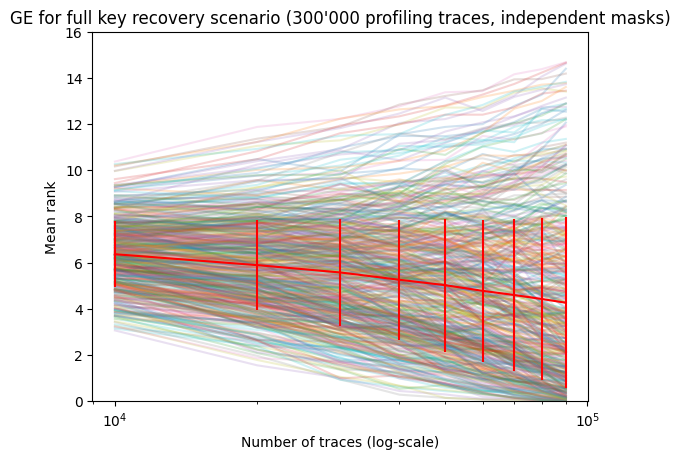

In [10]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces, independent masks)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

## 295'000 - 100'000, RWS first quarter

In [4]:
TEST_SIZE = 100_000

In [5]:
with open("y_extraction/y_extraction_rws_300000.pic", "rb") as r:
    y_predicted = pic.load(r)

In [8]:
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
rws_perm_probas = y_predicted[0]
rws_masks_probas = np.stack([np.stack(y_predicted[i:i+2], axis=1) for i in range(1, len(y_predicted), 2)], axis=1)

per_trace = rws_classifications_per_trace("preds_per_trace/per_trace_300000_rws.pic", seeds_extraction, rws_perm_probas, rws_masks_probas, parallel=True)
recovered_key = reconstruct_key(per_trace)

In [9]:
np.count_nonzero(recovered_key == key) / 512

0.556640625

In [10]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key, repeat=100)
with open("mean_ranks/mean_ranks_300000_rws.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


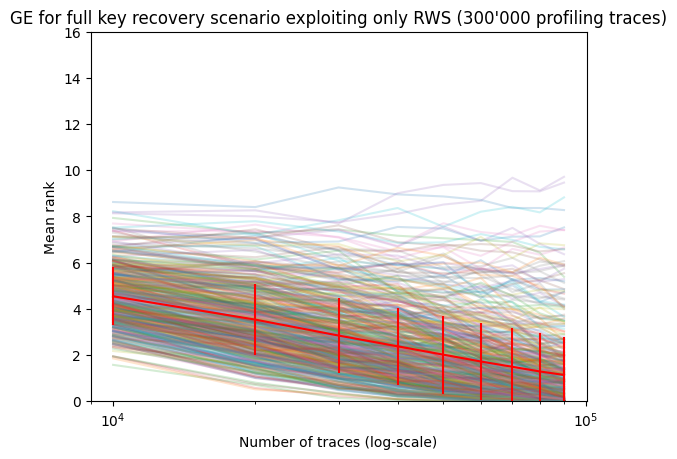

In [18]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario exploiting only RWS (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

## 295'000 - 100'000, RWS first quarter + round 0

In [4]:
TEST_SIZE = 100_000

In [81]:
with open("preds_per_trace/per_trace_300000_rws.pic", "rb") as r:
    per_trace_rws = pic.load(r)
with open("preds_per_trace/per_trace_300000_ind_masks.pic", "rb") as r:
    per_trace_rounds = pic.load(r)
per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [82]:
np.count_nonzero(recovered_key == key) / 512

0.60546875

## 500'000 - 240'000, Haar 2nd order, 1 big model

In [3]:
TRAIN_SIZE = 500_000

In [13]:
with open("y_extraction/y_extraction_500000_haar_2_epoch_33.pic", "rb") as r:
    y_predicted = pic.load(r)

In [9]:
_, rws_perms_true, _, round_perms_true, _, copy_perms_true, _, rws_masks_true, _, round_masks_true = train_test_split(rws_perms_labels, round_perms_labels, np.moveaxis(copy_perms_labels, -1, 0), np.moveaxis(rws_masks_labels, -1, 0), np.moveaxis(round_masks_labels, -1, 0), train_size=TRAIN_SIZE, random_state=0)
_, seeds_extraction = train_test_split(seeds_total, train_size=TRAIN_SIZE, random_state=0)
rws_perm_probas = y_predicted[0]
rws_masks_probas = np.stack([np.stack(y_predicted[keyround_idx:keyround_idx+NR_SHARES], axis=1) for keyround_idx in range(1, 1 + NR_SHARES * KEYROUND_WIDTH_B4, NR_SHARES)], axis=1)
round_perm_probas = y_predicted[1 + NR_SHARES * KEYROUND_WIDTH_B4]
copy_perm_probas = np.stack(y_predicted[1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1:1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND)], axis=1)
round_masks_probas = np.stack([np.stack([np.stack(y_predicted[block_idx:block_idx+NR_SHARES], axis=1) for block_idx in range(1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND) + 2 * round_idx * BLOCK_WIDTH_B4, 1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND) + 2 * (round_idx + 1) * BLOCK_WIDTH_B4, NR_SHARES)], axis=1) for round_idx in range(EARLIEST_ROUND, LATEST_ROUND)], axis=1)

In [26]:
np.mean(np.mean(np.argmax(rws_perm_probas, axis=-1) == rws_perms_true, axis=0)), np.std(np.mean(np.argmax(rws_perm_probas, axis=-1) == rws_perms_true, axis=0))

(0.7412178524674499, 0.0)

In [27]:
np.mean(np.mean(np.argmax(round_perm_probas, axis=-1) == round_perms_true, axis=0)), np.std(np.mean(np.argmax(round_perm_probas, axis=-1) == round_perms_true, axis=0))

(0.589310435688205, 0.0)

In [28]:
np.mean(np.mean(np.argmax(copy_perm_probas, axis=-1) == copy_perms_true, axis=0)), np.std(np.mean(np.argmax(copy_perm_probas, axis=-1) == copy_perms_true, axis=0))

(0.37709564299845066, 0.04072492074293587)

In [25]:
np.mean(np.mean(np.argmax(rws_masks_probas, axis=-1) == rws_masks_true, axis=0)), np.std(np.mean(np.argmax(rws_masks_probas, axis=-1) == rws_masks_true, axis=0))

(0.06849953869030725, 0.002567497087724598)

In [ ]:
np.mean(np.mean(np.argmax(round_masks_probas, axis=-1) == round_masks_true, axis=0)), np.std(np.mean(np.argmax(round_masks_probas, axis=-1) == round_masks_true, axis=0))

(0.0698145423218034, 0.0030659083362207344)

In [6]:
per_trace_rws = rws_classifications_per_trace("preds_per_trace/per_trace_500000_haar_2_epoch_33_rws.pic", seeds_extraction, rws_perm_probas, rws_masks_probas, parallel=True)
per_trace_rounds = classifications_per_trace("preds_per_trace/per_trace_500000_haar_2_epoch_33_rounds.pic", seeds_extraction, round_perm_probas, copy_perm_probas, round_masks_probas, parallel=True)

per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [17]:
with open("preds_per_trace/per_trace_500000_haar_2_epoch_33_rws.pic", "rb") as r:
    per_trace_rws = pic.load(r)
with open("preds_per_trace/per_trace_500000_haar_2_epoch_33_rounds.pic", "rb") as r:
    per_trace_rounds = pic.load(r)
per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [7]:
np.count_nonzero(reconstruct_key(per_trace_rws) == key) / 512

0.107421875

In [8]:
np.count_nonzero(reconstruct_key(per_trace_rounds) == key) / 512

0.08984375

In [9]:
np.count_nonzero(recovered_key == key) / 512

0.125

In [52]:
classifications_per_key_nibble = np.sum(per_trace_total, axis=0)
mean_ranks = compute_mean_ranks(per_trace_total, key, repeat=150)
with open("mean_ranks/mean_ranks_500000_haar_2_epoch_17.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
149
249
349
449
549
649
749
849
949


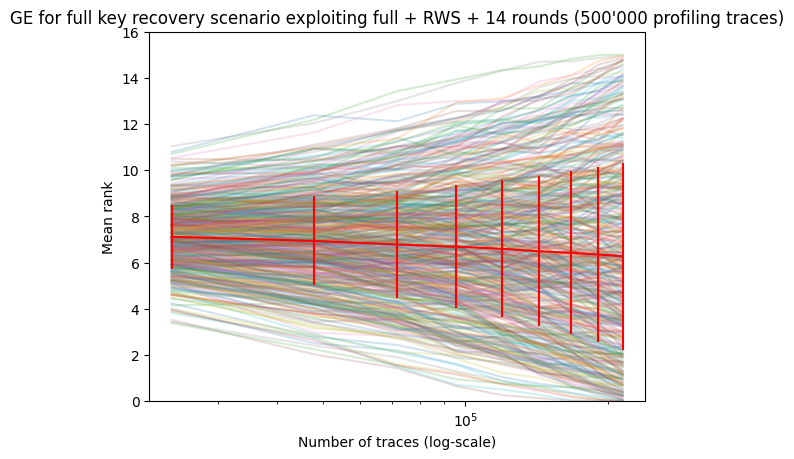

In [54]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace_total.shape[0], per_trace_total.shape[0] // 10)[1:-1], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace_total.shape[0], per_trace_total.shape[0] // 10)[1:-1], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario exploiting full + RWS + 14 rounds (500'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

## 750'000 - 240'000, 20 models

In [4]:
TRAIN_SIZE = 750_000

In [5]:
_, seeds_extraction = train_test_split(seeds_total, train_size=TRAIN_SIZE, random_state=0)

with open("y_extraction/y_extraction_750000_rws_perm.pic", "rb") as r:
    rws_perm_probas = pic.load(r)
rws_masks_probas = np.zeros((seeds_extraction.shape[0], KEYROUND_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET)), dtype=np.float64)
for i in range(0, 4):
    subkey = np.arange(i * (KEYROUND_WIDTH_B4 // 4), (i + 1) * (KEYROUND_WIDTH_B4 // 4) if i < 3 else KEYROUND_WIDTH_B4)
    with open(f"y_extraction/y_extraction_750000_rws_{i}.pic", "rb") as r:
        y_predicted = pic.load(r)
        rws_masks_probas[:, subkey, :, :] = np.stack([np.stack(y_predicted[keyround_idx:keyround_idx+NR_SHARES], axis=1) for keyround_idx in range(0, NR_SHARES * len(subkey), NR_SHARES)], axis=1)

with open("y_extraction/y_extraction_750000_round_perm.pic", "rb") as r:
    round_perm_probas = pic.load(r)
copy_perm_probas = np.zeros((seeds_extraction.shape[0], KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4), dtype=np.float64)
round_masks_probas = np.zeros((seeds_extraction.shape[0], KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET)), dtype=np.float64)
for round_idx in range(0, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    with open(f"y_extraction/y_extraction_750000_round_{round_idx}.pic", "rb") as r:
        y_predicted = pic.load(r)
        copy_perm_probas[:, round_idx, :] = y_predicted[0]
        round_masks_probas[:, round_idx, :, :, :] = np.stack([np.stack(y_predicted[block_idx:block_idx+NR_SHARES], axis=1) for block_idx in range(1, 1 + NR_SHARES * BLOCK_WIDTH_B4, NR_SHARES)], axis=1)

In [11]:
per_trace_rws = rws_classifications_per_trace("preds_per_trace/per_trace_750000_orig_rws_4_quarters.pic", seeds_extraction, rws_perm_probas, rws_masks_probas, parallel=True)

per_trace_rounds = classifications_per_trace("preds_per_trace/per_trace_750000_orig_all_rounds.pic", seeds_extraction, round_perm_probas, copy_perm_probas, round_masks_probas, parallel=True)

per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [46]:
with open("preds_per_trace/per_trace_750000_orig_rws_4_quarters.pic", "rb") as r:
    per_trace_rws = pic.load(r)
with open("preds_per_trace/per_trace_750000_orig_all_rounds.pic", "rb") as r:
    per_trace_rounds = pic.load(r)
per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [12]:
np.count_nonzero(reconstruct_key(per_trace_rws) == key) / 512

0.998046875

In [13]:
np.count_nonzero(reconstruct_key(per_trace_rounds) == key) / 512

0.65234375

In [14]:
np.count_nonzero(recovered_key == key) / 512

0.998046875

In [19]:
mean_ranks = compute_mean_ranks(per_trace_total, key, repeat=100)
with open("mean_ranks/mean_ranks_750000_rws_4_quarters_all_rounds.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


In [47]:
with open("mean_ranks/mean_ranks_750000_rws_4_quarters_all_rounds.pic", "rb") as r:
    mean_ranks = pic.load(r)

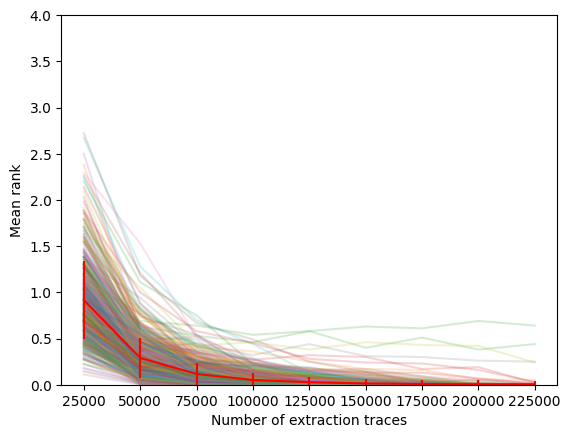

In [54]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot([i * per_trace_total.shape[0] // 10 for i in range(10)][1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar([i * per_trace_total.shape[0] // 10 for i in range(10)][1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
#plt.xscale("log")
#plt.title("GE graph with 20 neural networks (750'000 profiling traces)")
plt.xlabel("Number of extraction traces")
plt.ylabel("Mean rank")
plt.ylim([0, 4])
#plt.legend()
plt.show()

In [47]:
_, rws_perms_true, _, round_perms_true, _, copy_perms_true, _, rws_masks_true, _, round_masks_true = train_test_split(rws_perms_labels, round_perms_labels, np.moveaxis(copy_perms_labels, -1, 0), np.moveaxis(rws_masks_labels, -1, 0), np.moveaxis(round_masks_labels, -1, 0), train_size=TRAIN_SIZE, random_state=0)

In [48]:
np.count_nonzero(np.argmax(rws_perm_probas, axis=-1) == rws_perms_true) / rws_perms_true.shape[0]

0.9934959739838959

In [49]:
np.mean(guessing_entropy(rws_perm_probas, rws_perms_true))

0.01198004792019168

In [50]:
np.count_nonzero(np.argmax(round_perm_probas, axis=-1) == round_perms_true) / round_perms_true.shape[0]

0.7510590042360169

In [51]:
np.mean(guessing_entropy(round_perm_probas, round_perms_true))

0.38372953491813966

In [71]:
test_accuracies = []
for round_idx in range(copy_perms_true.shape[1]):
    test_accuracies.append(np.count_nonzero(np.argmax(copy_perm_probas[:, round_idx, :], axis=-1) == copy_perms_true[:, round_idx]) / copy_perms_true.shape[0])
print(f"{np.mean(test_accuracies)} +/- {np.std(test_accuracies)}")

0.602295552039351 +/- 0.0666007463399703


In [72]:
test_mean_ranks = []
for round_idx in range(copy_perms_true.shape[1]):
    test_mean_ranks.append(np.mean(guessing_entropy(copy_perm_probas[:, round_idx, :], copy_perms_true[:, round_idx])))
print(f"{np.mean(test_mean_ranks)} +/- {np.std(test_mean_ranks)}")

0.9070807711802277 +/- 0.187441017183112


In [73]:
test_accuracies = []
for keyround_idx in range(rws_masks_true.shape[1]):
    test_accuracies.append(np.count_nonzero(np.argmax(rws_masks_probas[:, keyround_idx, :], axis=-1) == rws_masks_true[:, keyround_idx]) / (rws_masks_true.shape[0] * rws_masks_true.shape[2]))
print(f"{np.mean(test_accuracies)} +/- {np.std(test_accuracies)}")

0.09584615889483966 +/- 0.002378252319697342


In [74]:
test_mean_ranks = []
for keyround_idx in range(rws_masks_true.shape[1]):
    test_mean_ranks.append(np.mean(guessing_entropy(rws_masks_probas[:, keyround_idx, :], rws_masks_true[:, keyround_idx])))
print(f"{np.mean(test_mean_ranks)} +/- {np.std(test_mean_ranks)}")

6.328846029669833 +/- 0.07790270096519042


In [76]:
test_accuracies = []
for round_idx in range(round_masks_true.shape[1]):
    for block_idx in range(round_masks_true.shape[2]):
        test_accuracies.append(np.count_nonzero(np.argmax(round_masks_probas[:, round_idx, block_idx, :], axis=-1) == round_masks_true[:, round_idx, block_idx]) / (round_masks_true.shape[0] * round_masks_true.shape[3]))
print(f"{np.mean(test_accuracies)} +/- {np.std(test_accuracies)}")

0.0843955416637993 +/- 0.005359034113553631


In [77]:
test_mean_ranks = []
for round_idx in range(round_masks_true.shape[1]):
    for block_idx in range(round_masks_true.shape[2]):
        test_mean_ranks.append(np.mean(guessing_entropy(round_masks_probas[:, round_idx, block_idx, :], round_masks_true[:, round_idx, block_idx])))
print(f"{np.mean(test_mean_ranks)} +/- {np.std(test_mean_ranks)}")

6.722869564947647 +/- 0.17863844206107565
